# This is a notebook for querying the CDI-incremental instance.
* You can run each cell individually by pressing "shift + enter".
* Please run the first few cells in order for the input widgets to appear.
* For more information, questions, bugs, please contact us on Slack:
    + https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2n95bd4rk-XMtZ9AVhVapwrFna1J5qmA.

#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token that you should receive via Blue-Cloud between the '' " in the cell below.

In [1]:
Token = ''

#### Importing the required packages.

In [2]:
import requests
import json
import xarray as xr
import datetime
from ipywidgets import interact, widgets, interactive
from IPython.display import Javascript, display
import pandas as pd
import os

#### This retrieves the available parameters from the footprint.

In [3]:
if not os.path.exists('./Footprint'):
    os.makedirs('Footprint')

responseinfo = requests.get("https://beacon-cdi-incremental.maris.nl/api/datasets/footprint", headers = {'Authorization' : f'Bearer {Token}'}) 
open('./Footprint/Footprint_CDI-incremental.json', 'wb').write(responseinfo.content)
with open('./Footprint/Footprint_CDI-incremental.json', 'r') as f:
    data = json.load(f)

pd.set_option('display.max_rows', 500)
attributes = pd.DataFrame.from_dict(data['unique_column_attributes'], orient='index')
attributes.reset_index(level=0, inplace=True)
attributes = attributes.sort_values('index', ascending=True, key=lambda col: col.str.lower())
params = attributes['index'].to_numpy()


#### In the widgets below, you should select your preferred filters and press "Execute all cells" to run the whole notebook.

In [4]:
def f(parameter, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp):
    return parameter, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp

w = interactive(f, parameter = params, minlon = (-180, 180, 1), maxlon = (-180, 180, 1), minlat = (-90, 90, 1), maxlat = (-90, 90, 1), mindepth = widgets.IntSlider(min = 0, max = 5000, value = 0), maxdepth = widgets.IntSlider(min = 0, max = 5000, value = 10), mintemp = widgets.DatePicker(description='Start date:', value = datetime.date(2000, 1, 1)), maxtemp = widgets.DatePicker(description='End date:', value = datetime.date(2003, 1, 1)))

display(w)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description = "Execute all cells")
button.on_click(run_all)
display(button)

interactive(children=(Dropdown(description='parameter', options=('ABCP', 'ABCP_SEADATANET_QC', 'ABSP620A', 'AB…

Button(description='Execute all cells', style=ButtonStyle())

#### Storing the chosen filters.

In [17]:
parameter = w.kwargs['parameter']
mintemp = w.kwargs['mintemp']
maxtemp = w.kwargs['maxtemp']
minlon = w.kwargs['minlon']
maxlon = w.kwargs['maxlon']
minlat = w.kwargs['minlat']
maxlat = w.kwargs['maxlat']
mindepth = w.kwargs['mindepth']
maxdepth = w.kwargs['maxdepth'] 

#### The fields below are fixed for the CDI-incremental instance.

In [18]:
unit = attributes.loc[attributes['index'] == parameter]['units'].iloc[0]
dateref = datetime.date(1950, 1, 1) 
mintemporal = (mintemp - dateref).days + 2433282.500000 #Days since -4713
maxtemporal = (maxtemp - dateref).days + 2433282.500000 #Days since -4713
regionname = f'[{minlat},{minlon}],[{maxlat},{maxlon}]' 

#### Query body based on your input fields, you can add other "query_parameters" and "filters" to suit your needs. 
* For more query examples, you can take a look at https://maris-development.github.io/beacon/available-nodes/blue-cloud-2026/seadatanet-cdi-incremental.html.  
* Instead of column_name "PRES" you can also use "DEPTH".

In [19]:
def query(parameter, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter
            },
            {
                "column_name": "TIME",
                "alias": "TIME"
            },
            {
                "column_name": "PRES",
                "alias": "DEPTH"
            },
            {
                "column_name": "LONGITUDE",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "LATITUDE",
                "alias": "LATITUDE"
            }
        ],
        "filters": [
            {
              "for_query_parameter": "TIME",
              "min": mintemporal,
              "max": maxtemporal
            },
            {
              "for_query_parameter": "DEPTH",
              "min": mindepth,
              "max": maxdepth
            },
            {
              "for_query_parameter": "LONGITUDE",
              "min": minlon,
              "max": maxlon
            },
            {
              "for_query_parameter": "LATITUDE",
              "min": minlat,
              "max": maxlat
            },
            {
              "for_query_parameter": parameter,
              "min": -2,
              "max": 40
            }
        ],
        "output": {
            "format": "netcdf"
        }}
    return body

query = query(parameter, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat)

#### This is the post request that is sent to Beacon with the above specified body.

In [20]:
response = requests.post("https://beacon-cdi-incremental.maris.nl/api/query", json.dumps(query), headers = {
    'Authorization' : f'Bearer {Token}',
    'Content-type': 'application/json'
})

if response.status_code == 204:
    print('No data has been found for your query, please update your input fields above and run the notebook again.')
elif response.status_code != 200:
    print(response.text)

#### This will create a Netcdf file in your directory with the name based on your filters, the output is shown here in a dataframe.

In [21]:
if not os.path.exists('./DataOutput'):
    os.makedirs('DataOutput')

open(f'./DataOutput/CDI-incremental_{parameter}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc', 'wb').write(response.content)
df = xr.open_dataset(f'./DataOutput/CDI-incremental_{parameter}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc').to_dataframe()
df

,TEMP,TIME,DEPTH,LONGITUDE,LATITUDE,dataset_id
INSTANCE,,,,,,
0,19.054000,2.456452e+06,1.00,7.904333,43.367833,3560878
1,19.179000,2.456452e+06,2.00,7.904333,43.367833,3560878
2,19.043000,2.456452e+06,3.00,7.904333,43.367833,3560878
3,18.730000,2.456452e+06,4.00,7.904333,43.367833,3560878
4,17.970000,2.456452e+06,5.00,7.904333,43.367833,3560878
...,...,...,...,...,...,...
2286301,17.904800,2.456791e+06,5.38,2.845865,36.794212,3319008
2286302,18.101801,2.456791e+06,4.67,2.845866,36.794216,3319008
2286303,18.487700,2.456791e+06,3.98,2.845866,36.794220,3319008


#### Plotting of results, if there are a lot of measurements, it may take quite some time (+-5 min).

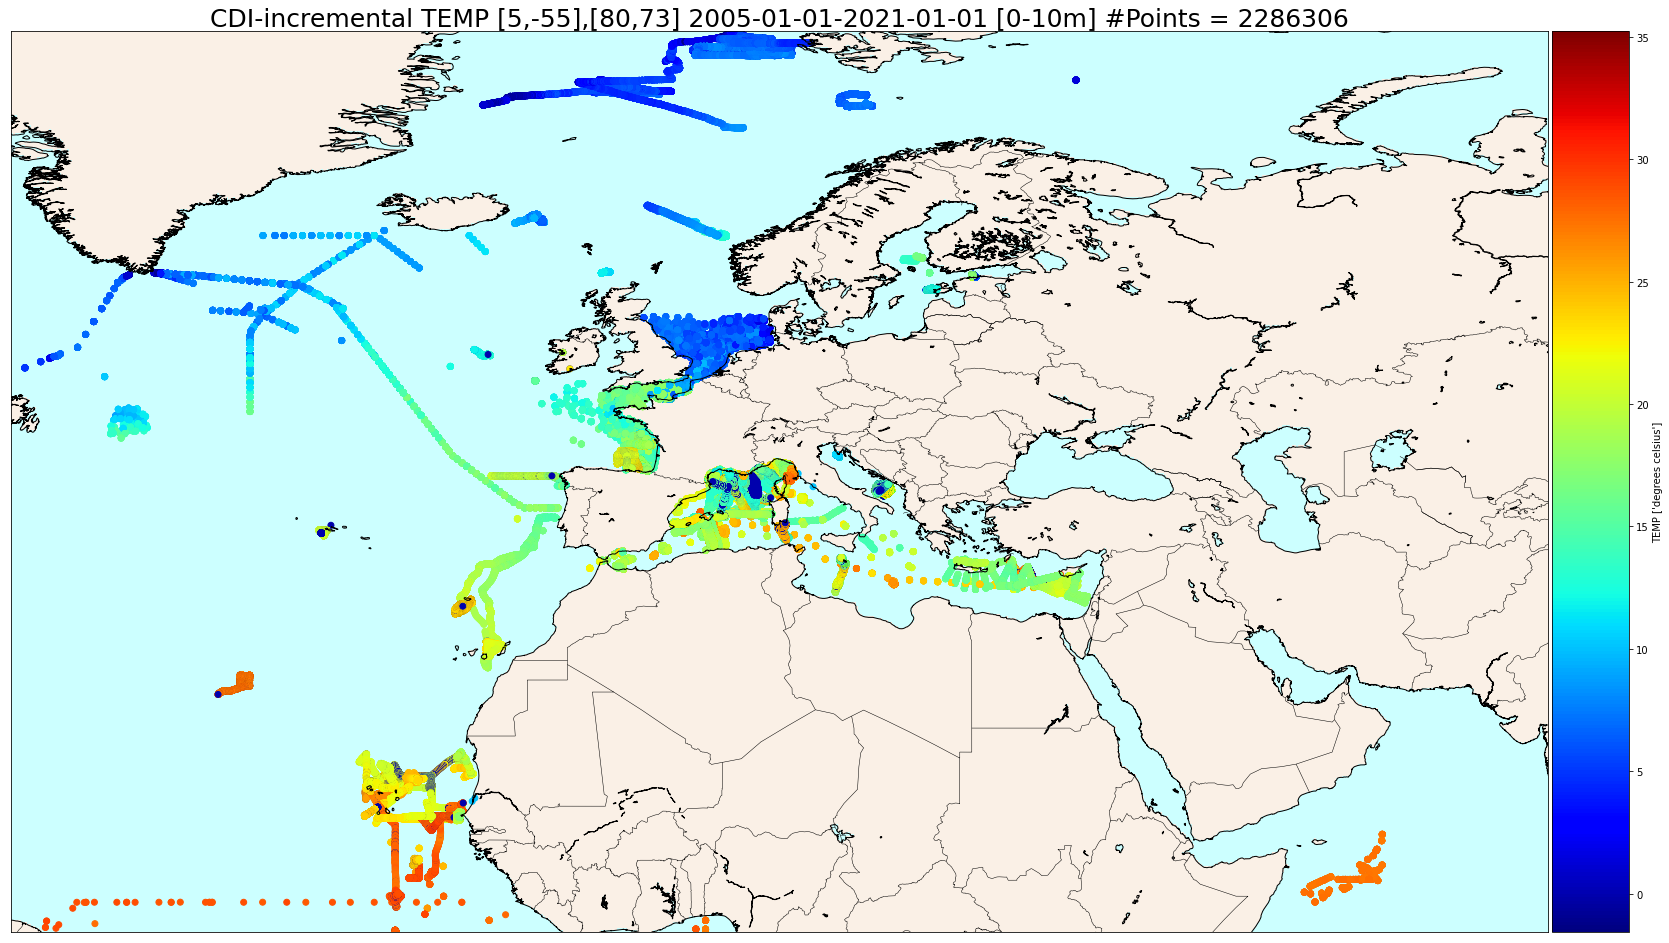

In [22]:
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(1, figsize = (29, 19))

m = Basemap(projection = 'cyl', llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat, resolution = 'i') 
m.drawlsmask(land_color = 'Linen', ocean_color = '#CCFFFF'); # can use HTML names or codes for colors
m.drawcoastlines()
m.drawcountries()

sc = m.scatter(df['LONGITUDE'], df['LATITUDE'], latlon = True, c = df[f'{parameter}'], cmap = plt.cm.jet)

plt.title(f'CDI-incremental {parameter} {regionname} {mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")} [{mindepth}-{maxdepth}m] #Points = {len(df)}', fontsize = 25)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(sc, cax = cax, label = f'{parameter} {unit}');